In [1]:
import os
from datasets import load_dataset, concatenate_datasets
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.initializers import Constant
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Embedding, Dropout, Flatten, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Embedding
from sklearn.metrics import confusion_matrix
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.text import Tokenizer
from matplotlib.pyplot import figure
import tensorflow.keras.backend as K

import seaborn as sn
import pandas as pd
import numpy as np
import string
import re
import tensorflow as tf
import nltk
import picke
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DMD028\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DMD028\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DMD028\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DMD028\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Ensure we are working with GPU
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

We will try different strategies:

Strategy 1:
- Tokenization
- To lowercase
- Glove

Strategy 2:
- Tokenization
- Punctuation removal
- Stop words removal
- To lowercase
- Glove

Strategy 3:
- Tokenization
- Punctuation removal
- Stop words removal
- Lemmatization
- To lowercase
- Glove

Strategy 4:
- Tokenization
- Punctuation removal
- Stop words removal
- Stemming
- To lowercase
- Glove

Strategy 5:
- Tokenization
- Punctuation removal
- Stop words removal
- Stemming
- Lemmatization
- To lowercase
- Glove

# Reatrieve data

In [3]:
# Data that already labels songs lyrics to a sentiment
dataset = load_dataset("Annanay/aml_song_lyrics_balanced")

In [4]:
# GloVe data
filename = '../datasets/Lyrics_dataset/glove.6B.100d.txt'

# Create dictionary of words embeddings
# This words embeddings are word representations in a vectorial space
# The vectors used for this project are the "Globol Vectors for Word Representation (Glove)"
# The size of the vectors is 100
file = open(filename, encoding = "utf-8")
embed_DB = {}
for a_line in file:
    embedding = a_line.split()
    the_word = embedding[0]
    context_array = embedding[1:]
    embed_DB[the_word] = np.asarray(context_array)
file.close()

Embedding using GloVe
- Tokenization
- NLTK work_tokenize: divide sentences into words
- Punctuation and Stop words removed
- Lemmatization -> reduce words to lemmas
- Stemming -> shorten words by removing morphological affixes to retain only the word stems
- Converting words into feature vectors 
- TfidfTransformer to transform the count matrix into a normalized TF (Term frequency) or TF-IDF (Term frequence-Inverse Document Frequency) representation.

In [5]:
def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return 'a'
        elif treebank_tag.startswith('V'):
            return 'v'
        elif treebank_tag.startswith('N'):
            return 'n'
        elif treebank_tag.startswith('R'):
            return 'r'
        else:
            return 'n'

In [6]:
def process_data(lyrics, stopwords, punctuation, lemmatize, stemmer):
    # Remove jump lines and song structure text "[]"
    lyrics_clean = []
    translator = str.maketrans('', '', string.punctuation)

    for lyric in lyrics:
        # Remove newlines and tags like [Verse], [Chorus], etc.
        cleaned_text = re.sub(r"\\n", " ", lyric)
        cleaned_text = re.sub(r"\[\w+.*?\]", "", cleaned_text)
        if punctuation:
            cleaned_text = cleaned_text.translate(translator)
        lyrics_clean.append(cleaned_text)

    # Separates a text into a list of tokens/words
    lyrics_tokens = []
    for lyric in lyrics_clean:
        tokens = word_tokenize(lyric) 
        lyrics_tokens.append(tokens)

    # Remove stopwords if necessary
    if stopwords:
        stopwords=nltk.corpus.stopwords.words('english') + ['@']
        no_stopwords_data = []

        for lyric in lyrics_tokens:
            temp = [word for word in lyric if not word in stopwords]
            no_stopwords_data.append(temp) 

        lyrics_tokens = no_stopwords_data

    # Remove stems from word lyrics
    if stemmer:
        stemmer = nltk.stem.LancasterStemmer()    
        X_stemmed = []

        for sentence in lyrics_tokens:
            temp = [stemmer.stem(word) for word in sentence]
            X_stemmed.append(temp)

    # Lemmatize the lyrics
    if lemmatize:
        lemmatizer = nltk.stem.WordNetLemmatizer()

        X_pos = []
        X_lemmatized = []

        for lyric in lyrics_tokens:
            temp = nltk.pos_tag(lyric) # Part of speech tagger
            X_pos.append(temp)
            
        for lyric in X_pos :
            temp = [ lemmatizer.lemmatize(word[0],pos=get_wordnet_pos(word[1])) for word in lyric]
            X_lemmatized.append(temp)  

        lyrics_tokens = X_lemmatized 

    # Transforms words to a sequence of numbers
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lyrics_tokens) # Updates vocabulary
    lyrics_sequence = tokenizer.texts_to_sequences(lyrics_tokens) 

    # Creates sparse matrix so every entry has the same dimensions
    highest_tokens = max([len(tokenized_lyric) for tokenized_lyric in lyrics_tokens]) # Number of maximum words
    lyrics_matrix = pad_sequences(lyrics_sequence, maxlen=highest_tokens) 

    # Making embedding matrix
    word_index = tokenizer.word_index
    total_words = len(word_index) + 1
    embed_mat = np.zeros((total_words, 100))
    
    for word, index in word_index.items():
        if index > total_words:
            continue
        embed_vec = embed_DB.get(word)
        # edge cases
        if embed_vec is None:
            continue
        embed_mat[index] = embed_vec
    
    return embed_mat, lyrics_matrix, total_words, highest_tokens, tokenizer

In [7]:
# Strat 1
train_data, train_mat, total_words1, highest_tokens1, tokenizer1 = process_data(dataset['train']['lyrics'], stopwords=False, punctuation=False, lemmatize=False, stemmer=False)
test_data, test_mat, total_words_test1, highest_tokens_test1, tokenizer_test1 = process_data(dataset['test']['lyrics'], stopwords=False, punctuation=False, lemmatize=False, stemmer=False)

In [8]:
# Strat 2
# train_data2, train_mat2, total_words2, highest_tokens2 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=False, stemmer=False)
# test_data2, test_mat2, total_words_test2, highest_tokens_test2 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=False, stemmer=False)

In [9]:
# Strat 3
# train_data3, train_mat3, total_words3, highest_tokens3 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=True, stemmer=False)
# test_data3, test_mat3, total_words_train3, highest_tokens_train3 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=True, stemmer=False)

In [10]:
# Strat 4
# train_data4, train_mat4, total_words4, highest_tokens4 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=False, stemmer=True)
# test_data4, test_mat4, total_words_test4, highest_tokens_test4 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=False, stemmer=True)

In [11]:
# Strat 5
# train_data5, train_mat5, total_words5, highest_tokens5 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=True, stemmer=True)
# test_data5, test_mat5, total_words_test5, highest_tokens_test5 = process_data(dataset['train']['lyrics'], stopwords=True, punctuation=True, lemmatize=True, stemmer=True)

In [12]:
# Compare the number of words and other parameters that are generated for each 

In [13]:
################################################################################################################################
# TF

In [14]:
def recall_m(y_true, y_pred):
    y_true_int = K.cast(y_true, 'float32')  # Cast y_true to float32
    y_pred_int = K.cast(y_pred, 'float32')  # Cast y_true to float32
    
    true_positives = y_true_int * y_pred_int
    possible_positives = K.sum(K.round(K.clip(y_true_int, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true_int = K.cast(y_true, 'float32')  # Cast y_true to float32
    y_pred_int = K.cast(y_pred, 'float32')  # Cast y_true to float32

    true_positives = K.sum(K.round(K.clip(y_true_int * y_pred_int, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    y_true_int = K.cast(y_true, 'float32')  # Cast y_true to float32
    y_pred_int = K.cast(y_pred, 'float32')  # Cast y_true to float32
    
    precision = precision_m(y_true_int, y_pred_int)
    recall = recall_m(y_true_int, y_pred_int)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
# lyrics_clean = []
# translator = str.maketrans('', '', string.punctuation)

# for lyric in dataset['train']['lyrics']:
#     # Remove newlines and tags like [Verse], [Chorus], etc.
#     cleaned_text = re.sub(r"\\n", " ", lyric)
#     cleaned_text = re.sub(r"\[\w+.*?\]", "", cleaned_text)
#     lyrics_clean.append(cleaned_text)

# # Separates a text into a list of tokens/words
# lyrics_tokens = []
# for lyric in lyrics_clean:
#     tokens = word_tokenize(lyric) 
#     lyrics_tokens.append(tokens)

In [16]:
# Join train and test datasets in order to have a better dictionary
Y = np.array(dataset['train']['mood_cats'])
encoder = LabelBinarizer()
Y = encoder.fit_transform(Y.tolist())
X_train, X_test, Y_train, Y_test = train_test_split(train_mat, Y, test_size=0.25, shuffle=True)

In [17]:
# Network 1
embedding_layer = Embedding(total_words1, 100,input_shape=(highest_tokens1,), embeddings_initializer=Constant(train_data),trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(64, 16, activation='relu'))
model.add(Conv1D(32, 8, activation='relu'))
model.add(Conv1D(16, 8, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4 , activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

with tf.device('/gpu:0'):
    history_model = model.fit(X_train, Y_train, batch_size=6, epochs=1, validation_data=(X_test, Y_test), verbose=2)

1525/1525 - 1420s - loss: 0.5653 - accuracy: 0.2713 - f1_m: 1.2468e-04 - precision_m: 0.0025 - recall_m: 0.0105 - val_loss: 0.5603 - val_accuracy: 0.2985 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0106 - 1420s/epoch - 931ms/step


In [18]:
#model.save("model1.h5")


In [19]:
# Results model 1
# Epoch 1/10
# 1144/1144 - 550s - loss: 0.5646 - accuracy: 0.2594 - f1_m: 2.1880e-04 - precision_m: 0.0068 - recall_m: 0.0079 - val_loss: 0.5613 - val_accuracy: 0.2870 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0079 - 550s/epoch - 481ms/step
# Epoch 2/10
# 1144/1144 - 546s - loss: 0.5551 - accuracy: 0.3107 - f1_m: 0.0022 - precision_m: 0.0917 - recall_m: 0.0083 - val_loss: 0.5395 - val_accuracy: 0.3608 - val_f1_m: 0.0053 - val_precision_m: 0.2561 - val_recall_m: 0.0090 - 546s/epoch - 478ms/step
# Epoch 3/10
# 1144/1144 - 548s - loss: 0.5032 - accuracy: 0.4239 - f1_m: 0.0164 - precision_m: 0.5630 - recall_m: 0.0110 - val_loss: 0.4756 - val_accuracy: 0.4618 - val_f1_m: 0.0210 - val_precision_m: 0.6444 - val_recall_m: 0.0125 - 548s/epoch - 479ms/step
# Epoch 4/10
# 1144/1144 - 586s - loss: 0.4172 - accuracy: 0.5273 - f1_m: 0.0251 - precision_m: 0.7221 - recall_m: 0.0146 - val_loss: 0.4175 - val_accuracy: 0.5359 - val_f1_m: 0.0251 - val_precision_m: 0.7199 - val_recall_m: 0.0148 - 586s/epoch - 512ms/step
# Epoch 5/10
# 1144/1144 - 572s - loss: 0.3663 - accuracy: 0.5952 - f1_m: 0.0294 - precision_m: 0.7072 - recall_m: 0.0167 - val_loss: 0.4009 - val_accuracy: 0.5674 - val_f1_m: 0.0284 - val_precision_m: 0.6277 - val_recall_m: 0.0163 - 572s/epoch - 500ms/step
# Epoch 6/10
# 1144/1144 - 568s - loss: 0.3293 - accuracy: 0.6414 - f1_m: 0.0327 - precision_m: 0.7111 - recall_m: 0.0185 - val_loss: 0.3745 - val_accuracy: 0.6146 - val_f1_m: 0.0308 - val_precision_m: 0.6851 - val_recall_m: 0.0176 - 568s/epoch - 497ms/step
# Epoch 7/10
# 1144/1144 - 573s - loss: 0.2918 - accuracy: 0.6804 - f1_m: 0.0354 - precision_m: 0.7348 - recall_m: 0.0201 - val_loss: 0.3525 - val_accuracy: 0.6504 - val_f1_m: 0.0337 - val_precision_m: 0.6961 - val_recall_m: 0.0193 - 573s/epoch - 501ms/step
# Epoch 8/10
# 1144/1144 - 525s - loss: 0.2580 - accuracy: 0.7170 - f1_m: 0.0378 - precision_m: 0.7566 - recall_m: 0.0214 - val_loss: 0.3417 - val_accuracy: 0.6632 - val_f1_m: 0.0350 - val_precision_m: 0.7041 - val_recall_m: 0.0201 - 525s/epoch - 459ms/step
# Epoch 9/10
# 1144/1144 - 535s - loss: 0.2377 - accuracy: 0.7389 - f1_m: 0.0390 - precision_m: 0.7671 - recall_m: 0.0221 - val_loss: 0.3583 - val_accuracy: 0.6884 - val_f1_m: 0.0362 - val_precision_m: 0.7100 - val_recall_m: 0.0208 - 535s/epoch - 467ms/step
# Epoch 10/10
# 1144/1144 - 551s - loss: 0.2225 - accuracy: 0.7666 - f1_m: 0.0404 - precision_m: 0.7793 - recall_m: 0.0229 - val_loss: 0.3487 - val_accuracy: 0.6884 - val_f1_m: 0.0369 - val_precision_m: 0.7077 - val_recall_m: 0.0212 - 551s/epoch - 481ms/step

In [39]:
help(load_model)

In [ ]:
from keras.models import load_model
model = load_model("model1.h5", custom_objects={'f1_m': f1_m,  'precision_m': precision_m, 'recall_m': recall_m} )

In [41]:
model.predict(s)

1/1 [==============================] - 0s 131ms/step


array([[0.24870084, 0.25098005, 0.24356094, 0.25675818]], dtype=float32)

In [ ]:
len(X_test[0])
Y_pred = model.predict(X_test[0:8])


In [ ]:
Y_pred

1/1 [==============================] - 0s 75ms/step


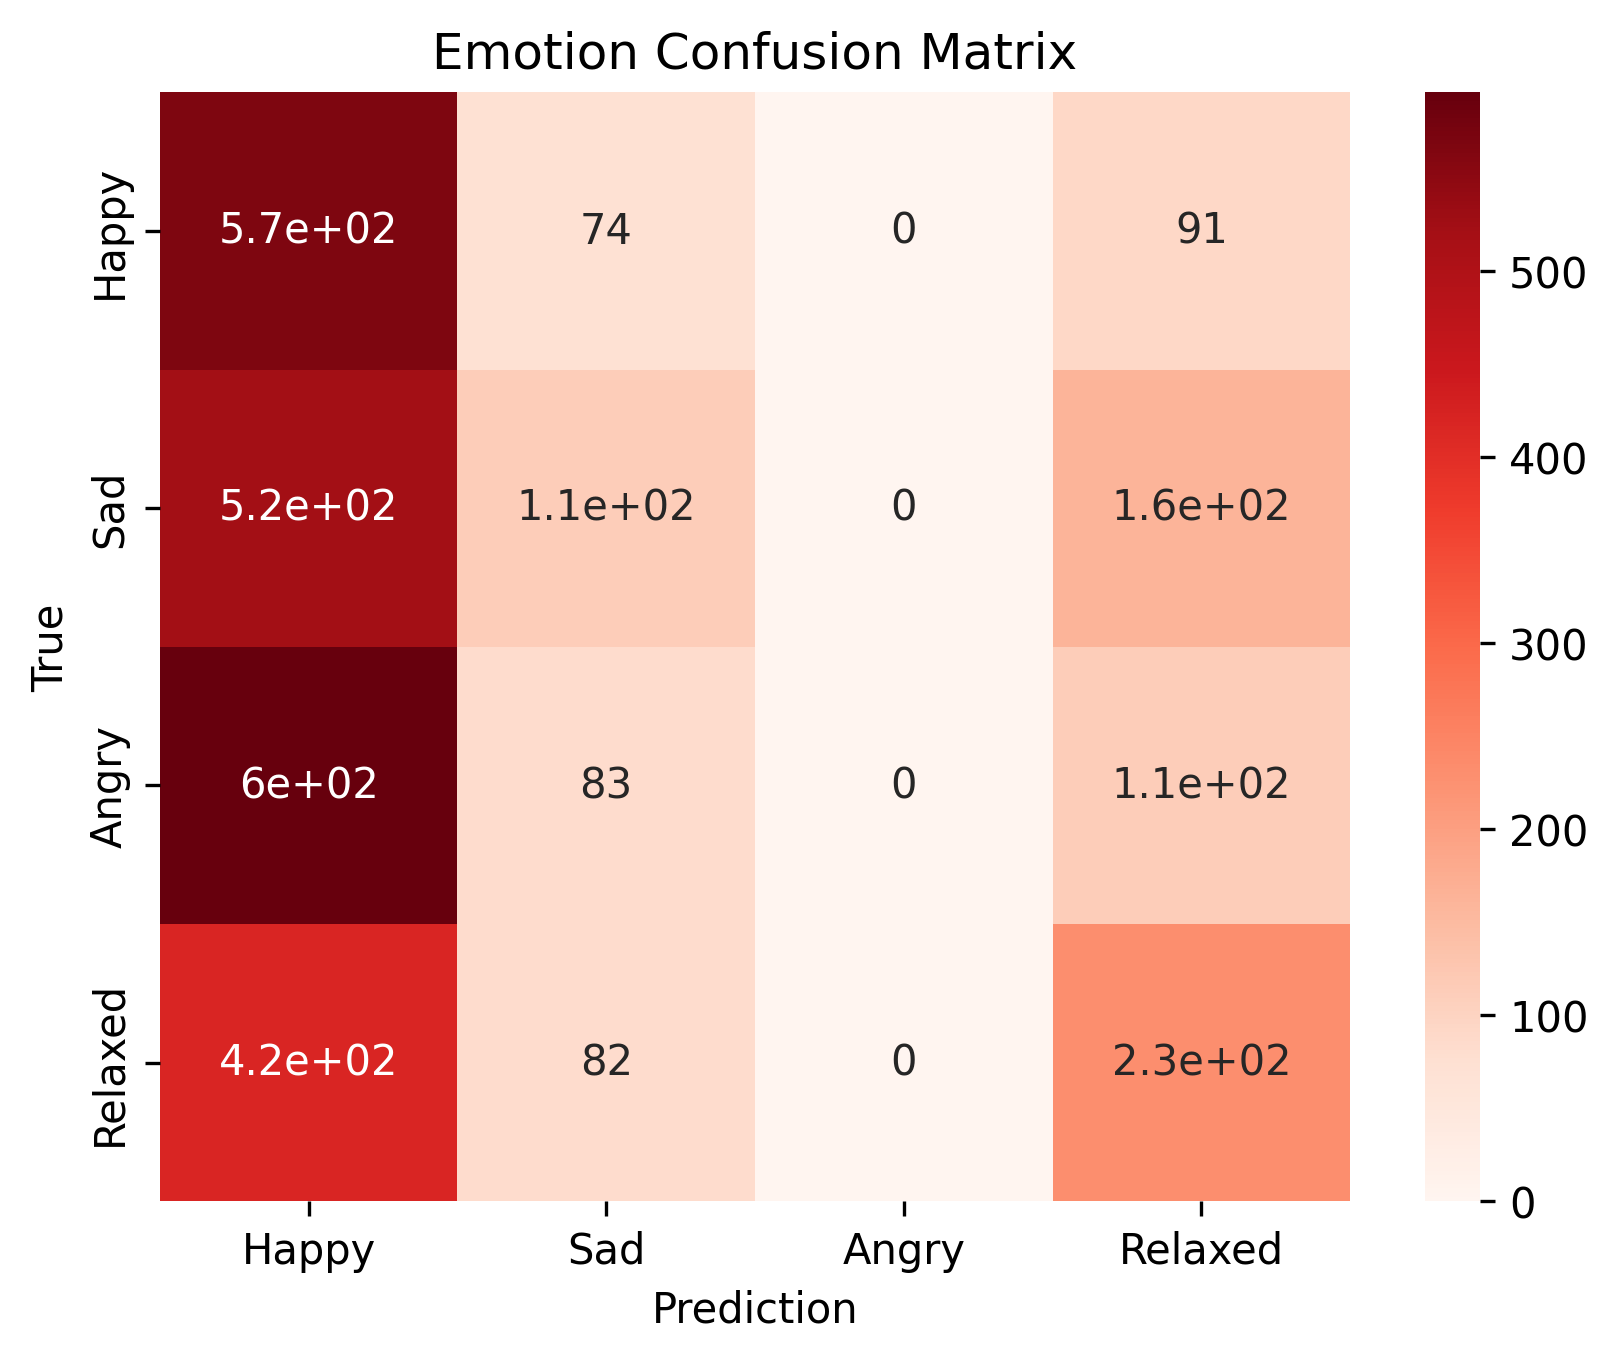

In [42]:
Y_pred = []
# Iterate through the test data in batches
for i in range(0, len(X_test), 8):
    # Get a batch of test data
    batch_X_test = X_test[i:i+8]

    # Predict on the batch
    batch_predictions = model.predict(batch_X_test)

    # Append batch predictions to the list of predictions
    Y_pred.append(batch_predictions)

# Concatenate predictions from all batches
Y_pred = np.concatenate(Y_pred)

y_pred_cat = np.zeros(len(Y_pred), dtype=int)
y_test_cat = np.zeros(len(Y_test), dtype=int)

for index, label in enumerate(Y_pred):
    y_pred_cat[index] = np.argmax(Y_pred[index])

for index, label in enumerate(Y_test):
    y_test_cat[index] = np.argmax(Y_test[index])

confusion_mat = confusion_matrix(y_test_cat, y_pred_cat)
confusion_df = pd.DataFrame(confusion_mat, index = ['Happy', 'Sad', 'Angry', 'Relaxed',], columns = ['Happy', 'Sad', 'Angry', 'Relaxed',])


figure(dpi=300)
sn.heatmap(confusion_df, annot=True, cmap=plt.cm.Reds, cbar=True)
plt.title('Emotion Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("True")
plt.savefig("../Images/Lyrics_classification/Model1 confusion mat")
plt.show()

In [43]:
some_text = "solo ride until"
translator2 = str.maketrans('', '', string.punctuation)
cleaned_text = re.sub(r"\\n", " ", some_text)
cleaned_text = re.sub(r"\[\w+.*?\]", "", cleaned_text)
s = [cleaned_text]

t = word_tokenize(some_text) 
s = [t]
s = tokenizer1.texts_to_sequences(s) 
s = pad_sequences(s, maxlen=highest_tokens1) 
s

array([[   0,    0,    0, ..., 4576,  437,  314]])

In [44]:
# Remove jump lines and song structure text "[]"
lyrics_clean2 = []
translator2 = str.maketrans('', '', string.punctuation)


for lyric in dataset['test']['lyrics']:
    # Remove newlines and tags like [Verse], [Chorus], etc.
    cleaned_text = re.sub(r"\\n", " ", lyric)
    cleaned_text = re.sub(r"\[\w+.*?\]", "", cleaned_text)
    lyrics_clean2.append(cleaned_text)

# Separates a text into a list of tokens/words
lyrics_tokens2 = []
for lyric in lyrics_clean2:
    tokens = word_tokenize(lyric) 
    lyrics_tokens2.append(tokens)

In [45]:
lyrics_sequence2 = tokenizer1.texts_to_sequences(lyrics_tokens2) 

# Creates sparse matrix so every entry has the same dimensions
lyrics_matrix = pad_sequences(lyrics_sequence2, maxlen=highest_tokens1) 

In [46]:
highest_tokens1

173033

In [47]:
lyrics_matrix

array([[ 0,  0,  0, ...,  1, 79, 29],
       [ 0,  0,  0, ...,  1, 79, 29],
       [ 0,  0,  0, ...,  1, 79, 29],
       ...,
       [ 0,  0,  0, ...,  1, 79, 29],
       [ 0,  0,  0, ...,  1, 79, 29],
       [ 0,  0,  0, ...,  1, 79, 29]])

In [48]:
Y_pred2 = []
# Iterate through the test data in batches
for i in range(0, len(lyrics_matrix), 8):
    # Get a batch of test data
    batch_X_test = lyrics_matrix[i:i+8]

    # Predict on the batch
    batch_predictions = model.predict(batch_X_test)

    # Append batch predictions to the list of predictions
    Y_pred2.append(batch_predictions)

Y_pred2 = np.concatenate(Y_pred2)


1/1 [==============================] - 0s 18ms/step


In [49]:
for i in range(len(Y_pred2)):
    print("Real: ", dataset['test']['mood_cats'][i])
    print("Pred: ", np.argmax(Y_pred2[i]))
    print(dataset['test']['lyrics'][i][0:100])

Real:  3
Pred:  1
"Fields of Desolation LyricsOn the fields of desolation\nWe are all alone\nCrying in each others arm
Real:  2
Pred:  0
"When You Come Back To Me LyricsNow that I've found you\nThe feeling won't leave my heart\nHolding o
Real:  0
Pred:  0
"Are You Magnetic? LyricsI'm on the phone I can't say anything, in case I say the wrong thing\nAnd y
Real:  0
Pred:  1
"Into The Ocean Lyrics[Verse 1]\nI'm just a normal boy\nThat sank when I fell overboard\nMy ship wou
Real:  1
Pred:  0
'Bonfires LyricsI was given wine\nWe’re feeling okay\nAnd quite all right\nYou wash my tears away\nA
Real:  0
Pred:  0
"Make the World Go Away Lyrics[Chorus]\nMake the world go away\nAnd get it off my shoulders\nSay the
Real:  0
Pred:  0
"More Today Than Yesterday LyricsI don't remember what day it was\nI didn't notice what time it was\
Real:  0
Pred:  1
"Two Tribes LyricsYeah..\nHa!\n\nWhen two tribes go to war\nA point is all that you can score\nScore
Real:  0
Pred:  0
"Don’t Stop Looking For Love L

In [50]:
y_pred_cat = np.zeros(len(Y_pred2), dtype=int)
y_test_cat = np.zeros(len(Y_pred2), dtype=int)

for index, label in enumerate(Y_pred2):
    y_pred_cat[index] = np.argmax(Y_pred2[index])

for index, label in enumerate(dataset['test']['mood_cats']):
    y_test_cat[index] = dataset['test']['mood_cats'][index]

confusion_mat = confusion_matrix(y_test_cat, y_pred_cat)
confusion_df = pd.DataFrame(confusion_mat, index = ['Happy', 'Sad', 'Angry', 'Relaxed',], columns = ['Happy', 'Sad', 'Angry', 'Relaxed',])


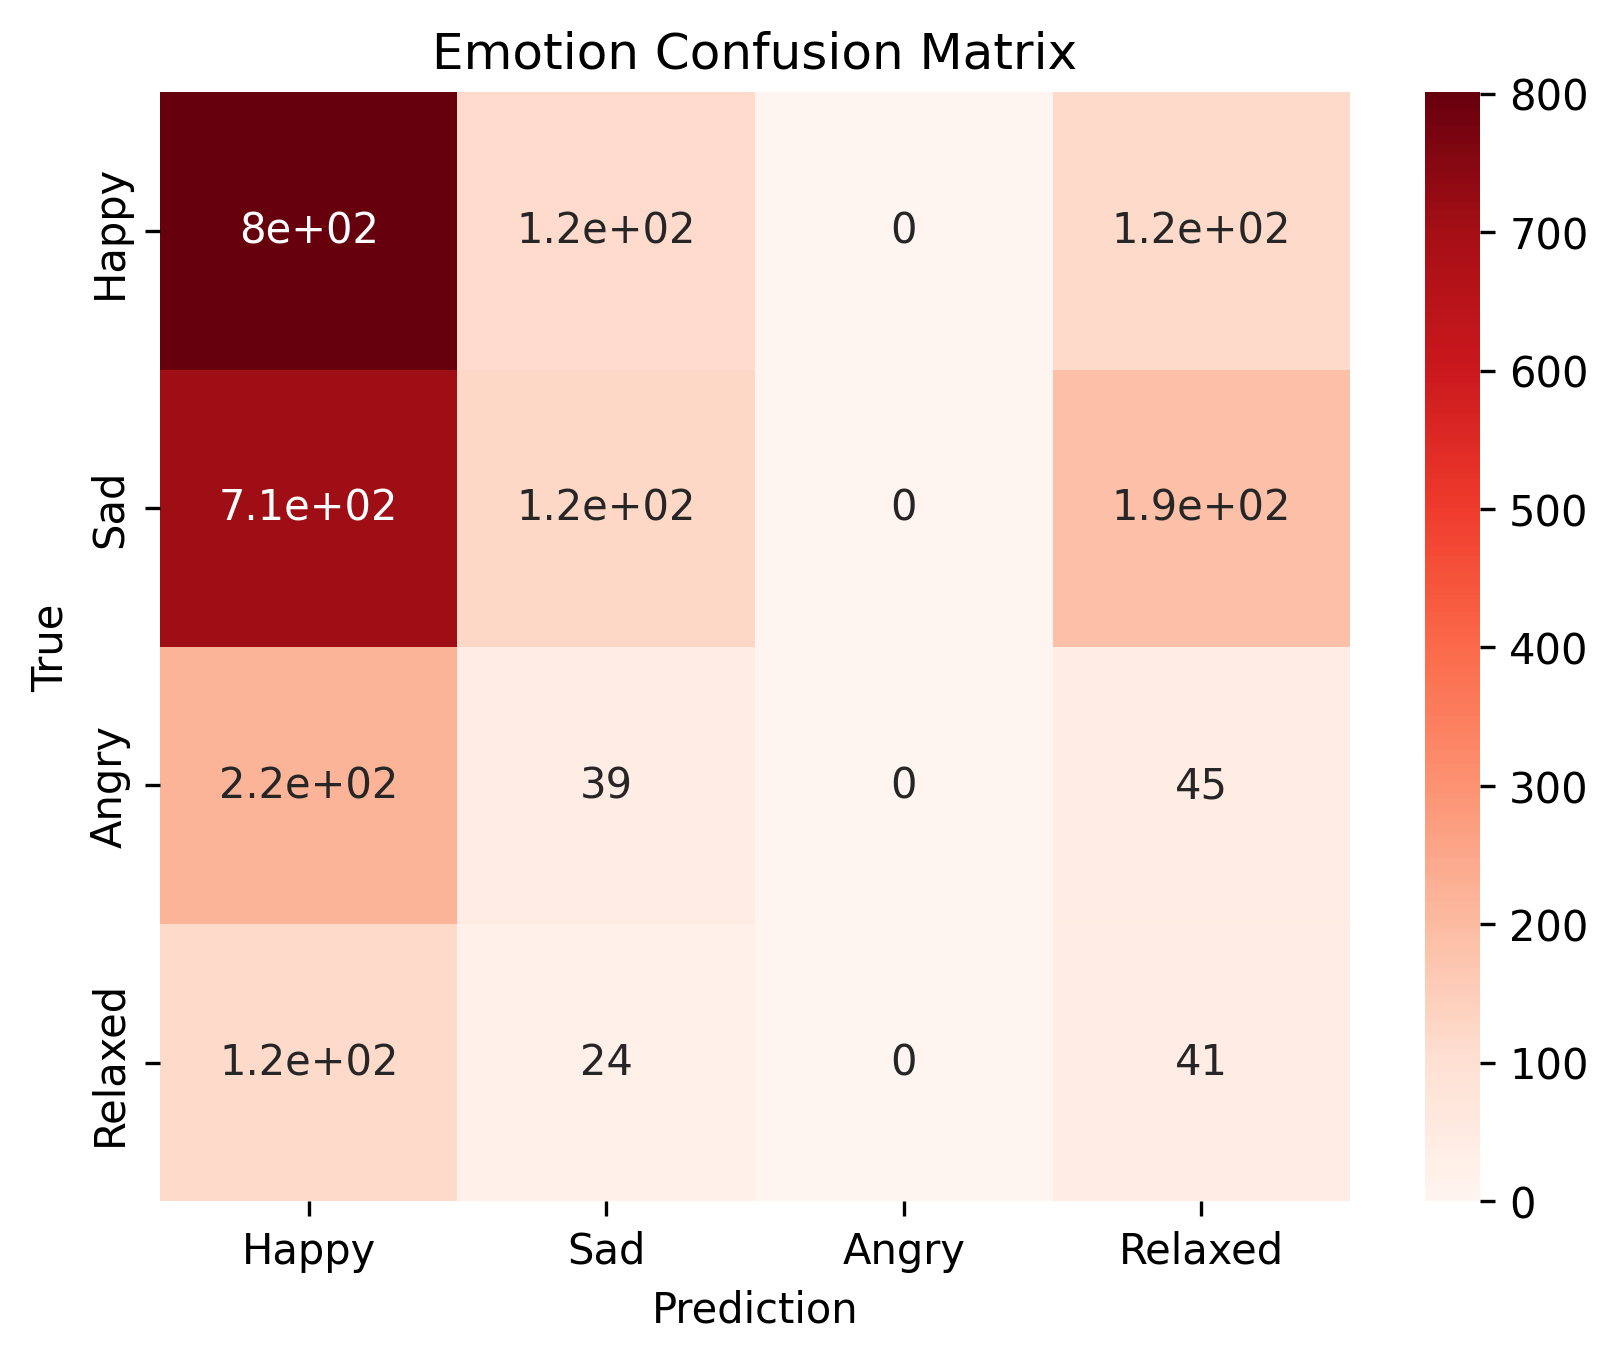

In [51]:
figure(dpi=300)
sn.heatmap(confusion_df, annot=True, cmap=plt.cm.Reds, cbar=True)
plt.title('Emotion Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("True")
plt.show()

In [52]:
# Network 2
embedding_layer = Embedding(total_words1, 100, embeddings_initializer=Constant(train_data), input_shape=(highest_tokens1,),trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(128, 16, activation='relu'))
model.add(Conv1D(64, 8, activation='relu'))
model.add(Conv1D(32, 8, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

with tf.device(‘/gpu:0’):
    history_model = model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_data=(X_test, Y_test), verbose=2)

SyntaxError: invalid character '‘' (U+2018) (1259130636.py, line 17)

In [ ]:
for i in y_test_cat:
    print(i)

In [ ]:
dataset['test']['mood_cats']

In [ ]:
# Keras model
# Define Classification model

np.random.seed(123)

model_2 = keras.models.Sequential(name='Model_2(Preprocessing +  GloVe 100D)')

model_2.add(InputLayer(input_shape=(20,),name='Integer_Encoding_after_Preprocessing'))
model_2.add(Embedding(total_words1, 100, weights=[train_data], input_length=highest_tokens1,mask_zero=True,
                      name='Pretrained_GloVe_100D', trainable=False))
model_2.add(Bidirectional(LSTM(64,name='LSTM'),name='Bidirectional_RNN'))
model_2.add(Dropout(0.5,name='Regularizer'))
model_2.add(Dense(1, activation='sigmoid',name='Sigmoid_Classifier'))
     

# Compile the Model

model_2.compile(optimizer=keras.optimizers.adam(lr=0.001),loss='binary_crossentropy',
                metrics=['accuracy'])
     

# Model details

model_2.summary()
keras.utils.plot_model(model_2,to_file='model_2.png')

In [ ]:
import keras
help(keras.backend.sum)

In [ ]:
import tensorflow.keras.backend as K2
help(K2.sum)